In [3]:
import json
from prettytable import PrettyTable
import json
import os
import random
import pandas as pd

def jsonl_to_json_list(jsonl_file_path):
    json_list = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip())  # Parse each line as JSON
            json_list.append(json_obj)
    
    return json_list

def save_as_json(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        json.dump(json_list, outfile, indent=4)

def save_as_jsonl(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for json_obj in json_list:
            json.dump(json_obj, outfile)
            outfile.write('\n')

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line.strip()) for line in file]
    return data

def deduplicate_data(data):
    seen = set()
    deduplicated_data = []
    for item in data:
        idx = item['realidx']
        if idx not in seen:
            deduplicated_data.append(item)
            seen.add(idx)
    return deduplicated_data

def calculate_cost_from_token_usage(data, model):
    total_cost = 0
    for item in data:
        if model == 'gpt-4o-mini':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 0.15 / 1000000 + item['token_usage']['all']['completion_tokens'] * 0.6 / 1000000
        elif model == 'gpt-4o':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 2.5 / 1000000 + item['token_usage']['all']['completion_tokens'] * 10 / 1000000
        elif model == 'o3-mini' or model == 'o1-mini':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 1.1 / 1000000 + item['token_usage']['all']['completion_tokens'] * 4.4 / 1000000
        elif model == 'claude-3-5-sonnet':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 3.0 / 1000000 + item['token_usage']['all']['completion_tokens'] * 15.0 / 1000000
        elif model == 'claude-3-5-haiku':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 0.8 / 1000000 + item['token_usage']['all']['completion_tokens'] * 4.0 / 1000000
        elif model == 'qwq':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 1.2 / 1000000 + item['token_usage']['all']['completion_tokens'] * 1.2 / 1000000
        elif model == 'qwen2.5':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 0.3 / 1000000 + item['token_usage']['all']['completion_tokens'] * 0.3 / 1000000
        elif model == 'r1':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 2.5 / 1000000 + item['token_usage']['all']['completion_tokens'] * 7 / 1000000
        elif model == 'v3':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 1.25 / 1000000 + item['token_usage']['all']['completion_tokens'] * 1.25 / 1000000
        elif model == 'llama3.3':
            total_cost += item['token_usage']['all']['prompt_tokens'] * 0.88 / 1000000 + item['token_usage']['all']['completion_tokens'] * 0.88 / 1000000
    return total_cost / len(data)

def calculate_time_from_data(data):
    total_time = 0
    for item in data:
        total_time += item['time_taken']
    return total_time / len(data)

In [1]:
# Load the data from the specified JSON file
file_path = "/home/ubuntu/MedAgents-2/output/medqa/20250416/gpt-4o-medqa-test_hard-retrieve-20-rerank-8-rewrite-True-review-False-adaptive_rag-auto-similarity_strategy-reuse-agent_memory-True.json"
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

deduplicated_data = deduplicate_data(data)
avg_cost = calculate_cost_from_token_usage(deduplicated_data, 'gpt-4o-mini')
avg_time = calculate_time_from_data(deduplicated_data)
print(f"After deduplication: {len(deduplicated_data)} items")
print(f"Average cost per item: ${avg_cost:.6f}")
print(f"Average time taken per item: {avg_time:.2f} seconds")

correct_count = 0
for item in deduplicated_data:
    if item['answer_idx'] == item['answer_by_turns'][-1]['answer']:
        correct_count += 1

print(f"Accuracy: {correct_count / len(deduplicated_data) * 100:.2f}%")

NameError: name 'json' is not defined

/tmp/ipykernel_1051404/1904026613.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Spectral', total_methods)
/tmp/ipykernel_1051404/1904026613.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Spectral', total_methods)


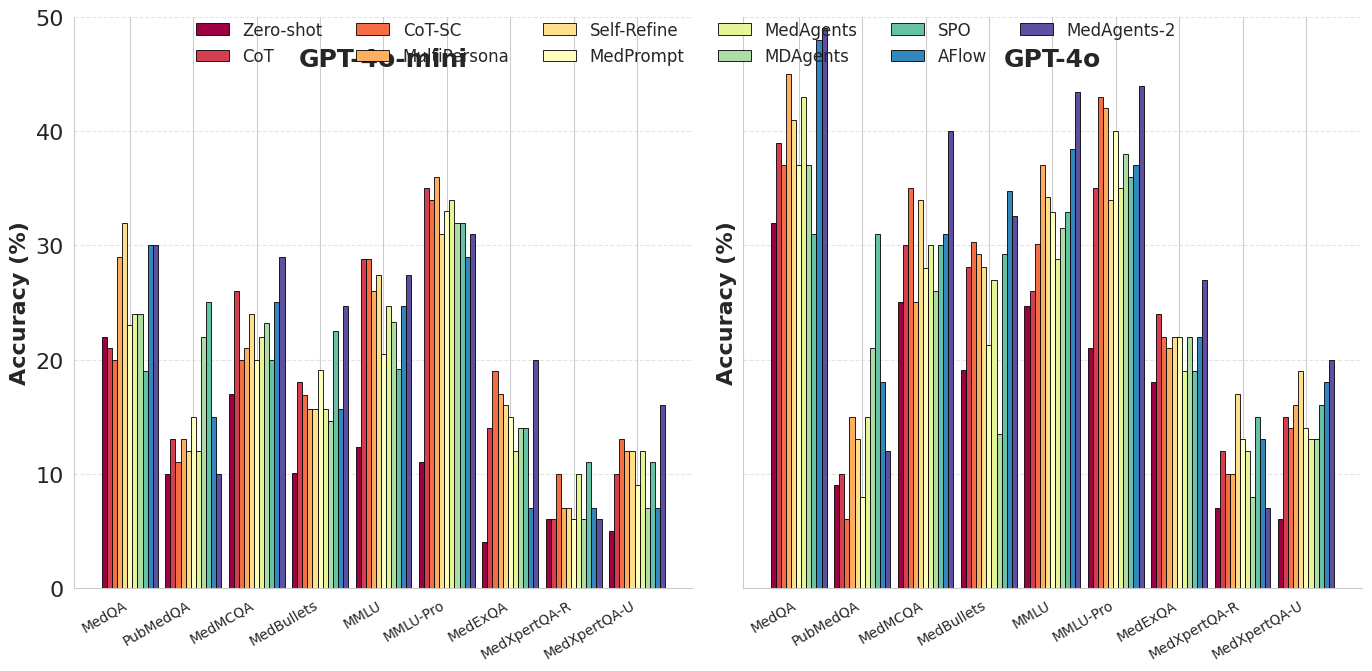

Performance Comparison Across Models and Tasks (Accuracy %)


Method,MedQA (GPT-4o-mini),PubMedQA (GPT-4o-mini),MedMCQA (GPT-4o-mini),MedBullets (GPT-4o-mini),MMLU (GPT-4o-mini),MMLU-Pro (GPT-4o-mini),MedExQA (GPT-4o-mini),MedXpertQA-R (GPT-4o-mini),MedXpertQA-U (GPT-4o-mini),MedQA (GPT-4o),PubMedQA (GPT-4o),MedMCQA (GPT-4o),MedBullets (GPT-4o),MMLU (GPT-4o),MMLU-Pro (GPT-4o),MedExQA (GPT-4o),MedXpertQA-R (GPT-4o),MedXpertQA-U (GPT-4o),Average (GPT-4o-mini),Average (GPT-4o)
MedAgents-2,30.0,10.0,29.0,24.7,27.4,31.0,20.0,6.0,16.0,49.0,12.0,40.0,32.6,43.4,44.0,27.0,7.0,20.0,21.6,30.6
AFlow,30.0,15.0,25.0,15.7,24.7,29.0,7.0,7.0,7.0,48.0,18.0,31.0,34.8,38.4,37.0,22.0,13.0,18.0,17.8,28.9
Self-Refine,32.0,12.0,24.0,15.7,27.4,31.0,16.0,7.0,12.0,41.0,13.0,34.0,28.1,34.2,34.0,22.0,17.0,19.0,19.7,26.9
SPO,19.0,25.0,20.0,22.5,19.2,32.0,14.0,11.0,11.0,31.0,31.0,30.0,29.2,32.9,36.0,19.0,15.0,16.0,19.3,26.7
MultiPersona,29.0,13.0,21.0,15.7,26.0,36.0,17.0,7.0,12.0,45.0,15.0,25.0,29.2,37.0,42.0,21.0,10.0,16.0,19.6,26.7
CoT-SC,20.0,11.0,20.0,16.9,28.8,34.0,19.0,10.0,13.0,37.0,6.0,35.0,30.3,30.1,43.0,22.0,10.0,14.0,19.2,25.3
MedAgents,24.0,12.0,22.0,15.7,24.7,34.0,12.0,10.0,12.0,43.0,15.0,30.0,27.0,28.8,35.0,19.0,12.0,13.0,18.5,24.8
CoT,21.0,13.0,26.0,18.0,28.8,35.0,14.0,6.0,10.0,39.0,10.0,30.0,28.1,26.0,35.0,24.0,12.0,15.0,19.1,24.3
MedPrompt,23.0,15.0,20.0,19.1,20.5,33.0,15.0,6.0,9.0,37.0,8.0,28.0,21.3,32.9,40.0,22.0,13.0,14.0,17.8,24.0
MDAgents,24.0,22.0,23.2,14.6,23.3,32.0,14.0,6.0,7.0,37.0,21.0,26.0,13.5,31.5,38.0,22.0,8.0,13.0,18.5,23.3



LaTeX Table:
\begin{table*}[t]
  \centering
  \small
  \setlength{\tabcolsep}{2.2mm}{
  \begin{tabular}{l|cc|cc|cc|cc|cc|cc|cc|cc|cc|cc}
    \toprule
    \textbf{Method} & \multicolumn{2}{c|}{MedQA} & \multicolumn{2}{c|}{PubMedQA} & \multicolumn{2}{c|}{MedMCQA} & \multicolumn{2}{c|}{MedBullets} & \multicolumn{2}{c|}{MMLU} & \multicolumn{2}{c|}{MMLU-Pro} & \multicolumn{2}{c|}{MedExQA} & \multicolumn{2}{c|}{MedXpertQA-R} & \multicolumn{2}{c|}{MedXpertQA-U} & \multicolumn{2}{c}{Average} \\
    \midrule
     & 4o-m & 4o & 4o-m & 4o & 4o-m & 4o & 4o-m & 4o & 4o-m & 4o & 4o-m & 4o & 4o-m & 4o & 4o-m & 4o & 4o-m & 4o & 4o-m & 4o \\
    \midrule
    MedAgents-2 & \underline{30.0} & \textbf{49.0} & 10.0 & 12.0 & \textbf{29.0} & \textbf{40.0} & \textbf{24.7} & \underline{32.6} & \underline{27.4} & \textbf{43.4} & 31.0 & \textbf{44.0} & \textbf{20.0} & \textbf{27.0} & 6.0 & 7.0 & \textbf{16.0} & \textbf{20.0} & \textbf{21.6} & \textbf{30.6} \\
    AFlow & \underline{30.0} & \underline{48.0} & 15

In [96]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import numpy as np
import pandas as pd
from IPython.display import display, HTML

sns.set_style("whitegrid")

tasks = ['MedQA', 'PubMedQA', 'MedMCQA', 'MedBullets', 'MMLU', 'MMLU-Pro', 'MedExQA', 'MedXpertQA-R', 'MedXpertQA-U']
model = ['gpt-4o-mini', 'gpt-4o']
methods = ['Zero-shot', 'CoT', 'CoT-SC', 'MultiPersona', 'Self-Refine', 'MedPrompt', 'MedAgents', 'MDAgents', 'SPO', 'AFlow', 'MedAgents-2']

# Group data by model
data_gpt4o_mini = {
    'Zero-shot': [22.0, 10.0, 17.0, 10.1, 12.3, 11.0, 4.0, 6.0, 5.0],
    'CoT': [21.0, 13.0, 26.0, 18.0, 28.8, 35.0, 14.0, 6.0, 10.0],
    'CoT-SC': [20.0, 11.0, 20.0, 16.9, 28.8, 34.0, 19.0, 10.0, 13.0],
    'MultiPersona': [29.0, 13.0, 21.0, 15.7, 26.0, 36.0, 17.0, 7.0, 12.0],
    'Self-Refine': [32.0, 12.0, 24.0, 15.7, 27.4, 31.0, 16.0, 7.0, 12.0],
    'MedPrompt': [23.0, 15.0, 20.0, 19.1, 20.5, 33.0, 15.0, 6.0, 9.0],
    'MedAgents': [24.0, 12.0, 22.0, 15.7, 24.7, 34.0, 12.0, 10.0, 12.0],
    'MDAgents': [24.0, 22.0, 23.2, 14.6, 23.3, 32.0, 14.0, 6.0, 7.0],
    'SPO': [19.0, 25.0, 20.0, 22.5, 19.2, 32.0, 14.0, 11.0, 11.0],
    'AFlow': [30.0, 15.0, 25.0, 15.7, 24.7, 29.0, 7.0, 7.0, 7.0],
    'MedAgents-2': [30.0, 10.0, 29.0, 24.7, 27.4, 31.0, 20.0, 6.0, 16.0]
}

data_gpt4o = {
    'Zero-shot': [32.0, 9.0, 25.0, 19.1, 24.7, 21.0, 18.0, 7.0, 6.0],
    'CoT': [39.0, 10.0, 30.0, 28.1, 26.0, 35.0, 24.0, 12.0, 15.0],
    'CoT-SC': [37.0, 6.0, 35.0, 30.3, 30.1, 43.0, 22.0, 10.0, 14.0],
    'MultiPersona': [45.0, 15.0, 25.0, 29.2, 37.0, 42.0, 21.0, 10.0, 16.0],
    'Self-Refine': [41.0, 13.0, 34.0, 28.1, 34.2, 34.0, 22.0, 17.0, 19.0],
    'MedPrompt': [37.0, 8.0, 28.0, 21.3, 32.9, 40.0, 22.0, 13.0, 14.0],
    'MedAgents': [43.0, 15.0, 30.0, 27.0, 28.8, 35.0, 19.0, 12.0, 13.0],
    'MDAgents': [37.0, 21.0, 26.0, 13.5, 31.5, 38.0, 22.0, 8.0, 13.0],
    'SPO': [31.0, 31.0, 30.0, 29.2, 32.9, 36.0, 19.0, 15.0, 16.0],
    'AFlow': [48.0, 18.0, 31.0, 34.8, 38.4, 37.0, 22.0, 13.0, 18.0],
    'MedAgents-2': [49.0, 12.0, 40.0, 32.6, 43.4, 44.0, 27.0, 7.0, 20.0]
}

# for dataset in ['MedQA', 'PubMedQA', 'MedMCQA', 'MedBullets', 'MMLU', 'MMLU-Pro', 'MedExQA', 'MedXpertQA-R', 'MedXpertQA-U']:
#     for model_name in ['gpt-4o-mini', 'gpt-4o']:
#         suffix = '-test_hard-retrieve-20-rerank-8-rewrite-True-review-False-adaptive_rag-auto-similarity_strategy-reuse-agent_memory-True.json'
#         prefix = '/home/ubuntu/MedAgents-2/output/' + dataset.lower() + '/20250416/'
#         file_path = prefix + model_name + '-' + dataset.lower() + suffix
#         with open(file_path, 'r', encoding='utf-8') as f:
#             json_data = json.load(f)
#         deduplicated_data = deduplicate_data(json_data)
#         correct_count = 0
#         for item in deduplicated_data:
#             if item['answer_idx'] == item['answer_by_turns'][-1]['answer']:
#                 correct_count += 1
#         accuracy = correct_count / len(deduplicated_data) * 100
#         idx = task.index(dataset)
#         if model_name == 'gpt-4o-mini':
#             data_gpt4o_mini['MedAgents-2'][idx] = accuracy
#         elif model_name == 'gpt-4o':
#             data_gpt4o['MedAgents-2'][idx] = accuracy


def plot_model_data(ax, data_dict, model_title):
    # Update global font settings for better appearance
    plt.rcParams.update({'font.size': 16, 'font.family': 'DejaVu Sans'})

    total_methods = len(methods)
    x = np.arange(len(tasks))
    width = 0.08
    offset_start = -((total_methods - 1) / 2.0) * width

    # Create a color palette
    color_map = plt.cm.get_cmap('Spectral', total_methods)

    for i, method_name in enumerate(methods):
        if method_name in data_dict:
            y_vals = data_dict[method_name]
            # Assign a color for each method
            bar_color = color_map(i / total_methods)
            ax.bar(
                x + offset_start + i * width,
                y_vals,
                width,
                label=method_name,
                color=bar_color,
                edgecolor='black',
                linewidth=0.6
            )

    ax.set_title(model_title, fontsize=18, fontweight='bold', y=0.9)
    ax.set_xticks(x)
    ax.set_xticklabels(tasks, rotation=30, ha='right', fontsize=10)
    ax.set_ylabel('Accuracy (%)', fontsize=16, fontweight='bold')
    ax.set_ylim(0, 50)

    ax.grid(axis='y', linestyle='--', alpha=0.5, color='#cccccc')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Adjust the figure size and overall layout
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

plot_model_data(axes[0], data_gpt4o_mini, 'GPT-4o-mini')

plot_model_data(axes[1], data_gpt4o, 'GPT-4o')

handles, labels = [], []
ax = axes[0]
h, l = ax.get_legend_handles_labels()
handles.extend(h)
labels.extend(l)

fig.legend(
    handles, 
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.97),
    ncol=6,
    frameon=False,
    fontsize=12
)

plt.subplots_adjust(left=0.05, right=0.98)  # Reduce margins on left and right
plt.savefig('gpt4o_mini_gpt4o_performance.pdf', dpi=300)
plt.tight_layout()
plt.show()

def calculate_average_performance(data):
    method_averages = {}
    
    for method_name, method_data in data.items():
        method_averages[method_name] = round(sum(method_data) / len(method_data), 1)
    
    return method_averages

gpt4o_mini_averages = calculate_average_performance(data_gpt4o_mini)
gpt4o_averages = calculate_average_performance(data_gpt4o)

comparison_data = []

for method in methods:
    row = {'Method': method}
    
    # Add individual task performances for GPT-4o-mini
    for i in range(len(tasks)):
        row[f'{tasks[i]} (GPT-4o-mini)'] = data_gpt4o_mini[method][i]
    
    # Add individual task performances for GPT-4o
    for i in range(len(tasks)):
        row[f'{tasks[i]} (GPT-4o)'] = data_gpt4o[method][i]
    
    # Add average performances
    row['Average (GPT-4o-mini)'] = gpt4o_mini_averages[method]
    row['Average (GPT-4o)'] = gpt4o_averages[method]
    
    comparison_data.append(row)

# Create DataFrame and sort by average performance (descending)
df = pd.DataFrame(comparison_data)
df = df.sort_values(by='Average (GPT-4o)', ascending=False)

# Find best and second best for each column
best_values = {}
second_best_values = {}
for col in df.columns:
    if col != 'Method':
        sorted_values = sorted(df[col].unique(), reverse=True)
        if len(sorted_values) >= 1:
            best_values[col] = sorted_values[0]
        if len(sorted_values) >= 2:
            second_best_values[col] = sorted_values[1]

# Format the table for display with best (bold) and second best (underline) values
formatted_df = df.copy()
for col in formatted_df.columns:
    if col != 'Method':
        formatted_df[col] = formatted_df[col].apply(
            lambda x: f"<b>{x:.1f}</b>" if x == best_values.get(col) else 
                     (f"<u>{x:.1f}</u>" if x == second_best_values.get(col) else f"{x:.1f}")
        )

# Display the table
print("Performance Comparison Across Models and Tasks (Accuracy %)")
display(HTML(formatted_df.to_html(index=False, escape=False)))

# Generate LaTeX table
print("\nLaTeX Table:")
print("\\begin{table*}[t]")
print("  \\centering")
print("  \\small")
print("  \\setlength{\\tabcolsep}{2.2mm}{")
print("  \\begin{tabular}{l|" + "cc|" * len(tasks) + "cc}")
print("    \\toprule")

# Header row with task names
header = ["\\textbf{Method}"]
for i in range(len(tasks)):
    header.append(f"\\multicolumn{{2}}{{c|}}{{{tasks[i]}}}")
header.append("\\multicolumn{2}{c}{Average}")
print("    " + " & ".join(header) + " \\\\")
print("    \\midrule")

# Subheader with model names
subheader = [""]
for _ in range(len(tasks) + 1):
    subheader.extend(["4o-m", "4o"])
print("    " + " & ".join(subheader) + " \\\\")
print("    \\midrule")

# Data rows with best (bold) and second best (underline) values
for _, row in df.iterrows():
    method = row['Method']
    row_data = [method]
    
    for i in range(len(tasks)):
        mini_val = row[f'{tasks[i]} (GPT-4o-mini)']
        full_val = row[f'{tasks[i]} (GPT-4o)']
        
        mini_formatted = f"\\textbf{{{mini_val:.1f}}}" if mini_val == best_values.get(f'{tasks[i]} (GPT-4o-mini)') else \
                        (f"\\underline{{{mini_val:.1f}}}" if mini_val == second_best_values.get(f'{tasks[i]} (GPT-4o-mini)') else f"{mini_val:.1f}")
        
        full_formatted = f"\\textbf{{{full_val:.1f}}}" if full_val == best_values.get(f'{tasks[i]} (GPT-4o)') else \
                        (f"\\underline{{{full_val:.1f}}}" if full_val == second_best_values.get(f'{tasks[i]} (GPT-4o)') else f"{full_val:.1f}")
        
        row_data.append(mini_formatted)
        row_data.append(full_formatted)
    
    # Average columns
    avg_mini = row['Average (GPT-4o-mini)']
    avg_full = row['Average (GPT-4o)']
    
    avg_mini_formatted = f"\\textbf{{{avg_mini:.1f}}}" if avg_mini == best_values.get('Average (GPT-4o-mini)') else \
                        (f"\\underline{{{avg_mini:.1f}}}" if avg_mini == second_best_values.get('Average (GPT-4o-mini)') else f"{avg_mini:.1f}")
    
    avg_full_formatted = f"\\textbf{{{avg_full:.1f}}}" if avg_full == best_values.get('Average (GPT-4o)') else \
                        (f"\\underline{{{avg_full:.1f}}}" if avg_full == second_best_values.get('Average (GPT-4o)') else f"{avg_full:.1f}")
    
    row_data.append(avg_mini_formatted)
    row_data.append(avg_full_formatted)
    
    print("    " + " & ".join(row_data) + " \\\\")

print("    \\bottomrule")
print("  \\end{tabular}")
print("  }")
print("  \\caption{Performance comparison of different methods across tasks and models. Values represent accuracy percentages. Bold numbers indicate the best performance in each column, while underlined numbers indicate the second-best performance.}")
print("  \\label{tab:performance_comparison}")
print("\\end{table*}")
